In [1]:
import pandas as pd
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from core import read_dom_table
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
systems_df = pd.read_csv('../data/raw/Beaker validation domains - hit_proteins.csv')


In [5]:
systems_df['working_id'].nunique()

42

In [4]:
hit_msa_dir = '../data/interim/hit_msas/'

In [5]:
msa_dir = '../data/interim/pd_prefilt_msas/'
built_msas = [x[:-4] for x in os.listdir(msa_dir) if '.a3m' in x]
msa_dir2 = '../data/interim/ecor_novel_domain_protein_msas/'
built_msas2 = [x[:-4] for x in os.listdir(msa_dir2) if '.a3m' in x]
msa_dir3 = '../data/interim/ecor_putative_novel_msas/'
built_msas3 = [x[:-4] for x in os.listdir(msa_dir3) if '.a3m' in x]
msa_dir4 = hit_msa_dir
built_msas4 = [x[:-4] for x in os.listdir(msa_dir4) if '.a3m' in x]

In [6]:
if 'hit_msas' not in os.listdir('../data/interim/'):
    os.mkdir(hit_msa_dir)

In [7]:
missing_msas = []
for acc in systems_df['product_accession']:
    if acc in built_msas:
        pass
    elif acc in built_msas2: 
        pass
    elif acc in built_msas3:
        pass
    elif acc in built_msas4:
        pass
    else:
        missing_msas.append(acc)
            

In [8]:
missing_msas

[]

In [15]:
missing_msas = pd.Series(missing_msas)
out_missing_accs = '../data/interim/validated_proteins_msas.txt'
missing_msas.to_csv(out_missing_accs, index=False)
out_missing_faa = '../data/interim/validated_missing_msas.faa'
if 'validated_missing_msas.faa' in os.listdir('../data/interim/'):
    os.system('rm ' + out_missing_faa)
os.system(' '.join(['conda run -n beaker', 
                    'seqtk subseq', 
                    '../data/interim/ecor_unique_seqs.faa', 
                    out_missing_accs, '>' , 
                    out_missing_faa]))

0

In [16]:
os.system(' '.join(['conda run -n hhpred python',
                    '~/Documents/hhpred/code/hhpred.py', 
                    '--in_fasta', out_missing_faa,
                    '--n_iter 2',
                    '--n_jobs 40',
                    '--alignment_dir', hit_msa_dir, 
                    '--no-search_dbs']))

Building multiple sequence alignments from fasta
Wirting out individual fasta files to ~/Documents/hhpred/data/temp/temp_fasta/
Transferring the Uniclust database to a the local filesystem
Wirting out MSAs from uniclust to ../data/interim/hit_msas/
Reusing MSAs
Generating multiple sequence alignments with 2 iterations of HHblits



100%|██████████| 1/1 [00:00<00:00,  8.48it/s]



0

In [6]:
len(systems_df['product_accession'])

68

In [10]:
for acc in systems_df['product_accession']:
    if acc in built_msas4:
        pass
    elif acc in built_msas:
        os.system('cp ' + msa_dir + acc + '.a3m ' + hit_msa_dir)
    elif acc in built_msas2: 
        os.system('cp ' + msa_dir2 + acc + '.a3m ' + hit_msa_dir)
    elif acc in built_msas3:
        os.system('cp ' + msa_dir3 + acc + '.a3m ' + hit_msa_dir)
            

In [11]:
for f in os.listdir(hit_msa_dir):
    if '.a3m' in f:
        acc = f[:-4]
        if acc not in systems_df['product_accession'].to_list():
            print(acc)

In [12]:
hit_msa_dir2 = '../data/interim/hit_msas_2/'
if 'hit_msas_2' in os.listdir('../data/interim/'):
    os.system('rm -r ' + hit_msa_dir2)
    os.mkdir(hit_msa_dir2)

In [13]:
a3m_files = [x for x in os.listdir(hit_msa_dir) if '.a3m' in x]

We will rename the duplicated IDs in the hmm

In [14]:
for f in tqdm(a3m_files, position=0):
    os.system(' '.join(['conda run -n beaker', 
                        'seqkit rename',  
                        hit_msa_dir + f, '>',
                        hit_msa_dir2 + f])) 

100%|██████████| 73/73 [01:46<00:00,  1.45s/it]


In [15]:
os.system(' '.join(['conda run -n beaker', 
                            '~/hhsuite/scripts/reformat.pl', 
                            'a3m', 
                            'sto',
                            hit_msa_dir2 + "\'*.a3m\'", 
                            '.stockholm', 
                            '-v 0']))

73 files to reformat
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserting gaps...
inserti

0

In [16]:
stockholm_files = [x for x in os.listdir(hit_msa_dir2) if '.stockholm' in x]

In [18]:
hmm_dir = '../data/interim/hit_hmms/'


In [18]:
if 'hit_hmms' in os.listdir('../data/interim'):
    os.system('rm -r ' + hmm_dir)
    os.mkdir(hmm_dir)

In [19]:
for f in tqdm(stockholm_files, position=0):
    p_id = f.split('.st')[0]
    hmm_out = hmm_dir + p_id + '.hmm'
    os.system(' '.join(['conda run -n beaker', 
                        'hmmbuild', 
                        hmm_out, 
                        hit_msa_dir2 + f])) 

  1%|▏         | 1/73 [00:01<02:13,  1.86s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_033812887.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_033812887.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_033812887.1        1697  3266   461    90.99  0.590 

# CPU time: 0.43u 0.01s 00:00:00.44 Elapsed: 00:00:00.47



  3%|▎         | 2/73 [00:03<01:58,  1.67s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000377448.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000377448.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000377448.1         295   669   318    14.37  0.590 

# CPU time: 0.19u 0.00s 00:00:00.19 Elapsed: 00:00:00.20



  4%|▍         | 3/73 [00:04<01:48,  1.56s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_021552536.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_021552536.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_021552536.1         265   238   132     9.28  0.590 

# CPU time: 0.08u 0.00s 00:00:00.08 Elapsed: 00:00:00.10



  5%|▌         | 4/73 [00:06<01:42,  1.49s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000628292.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000628292.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000628292.1        1005   149    74    15.39  0.763 

# CPU time: 0.05u 0.00s 00:00:00.05 Elapsed: 00:00:00.07



  7%|▋         | 5/73 [00:08<01:57,  1.72s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001676491.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001676491.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001676491.1        3727  4633   535   135.03  0.590 

# CPU time: 0.78u 0.02s 00:00:00.80 Elapsed: 00:00:00.82



  8%|▊         | 6/73 [00:10<02:10,  1.95s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_040091717.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_040091717.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_040091717.1        4046  5796   726    95.51  0.590 

# CPU time: 1.06u 0.01s 00:00:01.07 Elapsed: 00:00:01.09



 10%|▉         | 7/73 [00:12<02:00,  1.82s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001532221.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001532221.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001532221.1         301   735   362    13.74  0.590 

# CPU time: 0.22u 0.00s 00:00:00.22 Elapsed: 00:00:00.23



 11%|█         | 8/73 [00:13<01:53,  1.74s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000389051.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000389051.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000389051.1        1665  1629   244    25.23  0.590 

# CPU time: 0.23u 0.00s 00:00:00.23 Elapsed: 00:00:00.26



 12%|█▏        | 9/73 [00:15<01:57,  1.84s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_087889773.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_087889773.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_087889773.1        2570  9819   547  2570.00  0.580 

# CPU time: 0.66u 0.02s 00:00:00.68 Elapsed: 00:00:00.71



 14%|█▎        | 10/73 [00:17<01:51,  1.76s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000770925.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000770925.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000770925.1        2411  3729   225  2411.00  0.543 

# CPU time: 0.22u 0.03s 00:00:00.25 Elapsed: 00:00:00.27



 15%|█▌        | 11/73 [00:18<01:43,  1.66s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001024069.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001024069.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001024069.1          90   263   185    11.40  0.590 

# CPU time: 0.11u 0.00s 00:00:00.11 Elapsed: 00:00:00.12



 16%|█▋        | 12/73 [00:20<01:38,  1.61s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_087906371.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_087906371.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_087906371.1         517   499   273    13.99  0.590 

# CPU time: 0.17u 0.00s 00:00:00.17 Elapsed: 00:00:00.19



 18%|█▊        | 13/73 [00:21<01:33,  1.55s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_060581740.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_060581740.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_060581740.1         295   302   128     7.79  0.590 

# CPU time: 0.08u 0.00s 00:00:00.08 Elapsed: 00:00:00.09



 19%|█▉        | 14/73 [00:23<01:31,  1.55s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001703029.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001703029.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001703029.1         244   497   345     5.89  0.590 

# CPU time: 0.21u 0.00s 00:00:00.21 Elapsed: 00:00:00.22



 21%|██        | 15/73 [00:24<01:30,  1.56s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_014639476.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_014639476.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_014639476.1        1224  1098   308    25.03  0.590 

# CPU time: 0.23u 0.00s 00:00:00.23 Elapsed: 00:00:00.25



 22%|██▏       | 16/73 [00:26<01:30,  1.59s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001313577.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001313577.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001313577.1        2283  2422   347    31.10  0.590 

# CPU time: 0.36u 0.00s 00:00:00.36 Elapsed: 00:00:00.37



 23%|██▎       | 17/73 [00:28<01:27,  1.56s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001557682.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001557682.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001557682.1         724   661   206    12.75  0.590 

# CPU time: 0.15u 0.00s 00:00:00.15 Elapsed: 00:00:00.17



 25%|██▍       | 18/73 [00:29<01:24,  1.53s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001057122.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001057122.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001057122.1          29   237   217     2.31  0.590 

# CPU time: 0.11u 0.00s 00:00:00.11 Elapsed: 00:00:00.13



 26%|██▌       | 19/73 [00:31<01:25,  1.59s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_087897267.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_087897267.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_087897267.1        1305  2851   467    33.64  0.590 

# CPU time: 0.38u 0.00s 00:00:00.38 Elapsed: 00:00:00.40



 27%|██▋       | 20/73 [00:32<01:22,  1.57s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000354965.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000354965.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000354965.1         129   529   334     7.07  0.590 

# CPU time: 0.19u 0.00s 00:00:00.19 Elapsed: 00:00:00.19



 29%|██▉       | 21/73 [00:34<01:22,  1.58s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001240354.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001240354.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001240354.1        1779  1467   325    34.69  0.590 

# CPU time: 0.28u 0.01s 00:00:00.29 Elapsed: 00:00:00.30



 30%|███       | 22/73 [00:36<01:23,  1.63s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_054626965.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_054626965.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_054626965.1        1101  2804   525    59.05  0.590 

# CPU time: 0.42u 0.00s 00:00:00.42 Elapsed: 00:00:00.43



 32%|███▏      | 23/73 [00:38<01:26,  1.74s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001702960.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001702960.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001702960.1        2297  6905   401   174.55  0.590 

# CPU time: 0.62u 0.03s 00:00:00.65 Elapsed: 00:00:00.66



 33%|███▎      | 24/73 [00:39<01:20,  1.65s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_021513008.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_021513008.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_021513008.1         396   459   163     6.73  0.590 

# CPU time: 0.11u 0.00s 00:00:00.11 Elapsed: 00:00:00.13



 34%|███▍      | 25/73 [00:41<01:16,  1.60s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001022716.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001022716.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001022716.1         307   547   233    18.46  0.590 

# CPU time: 0.14u 0.00s 00:00:00.14 Elapsed: 00:00:00.16



 36%|███▌      | 26/73 [00:42<01:13,  1.55s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_021529611.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_021529611.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_021529611.1          97   439   242     6.92  0.590 

# CPU time: 0.14u 0.00s 00:00:00.14 Elapsed: 00:00:00.15



 37%|███▋      | 27/73 [00:44<01:12,  1.58s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_225403053.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_225403053.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_225403053.1        2483  1204   346    45.88  0.590 

# CPU time: 0.30u 0.01s 00:00:00.31 Elapsed: 00:00:00.32



 38%|███▊      | 28/73 [00:45<01:11,  1.58s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_016240615.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_016240615.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_016240615.1        1194  2330   270    25.99  0.590 

# CPU time: 0.23u 0.01s 00:00:00.24 Elapsed: 00:00:00.25



 40%|███▉      | 29/73 [00:47<01:09,  1.57s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001676492.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001676492.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001676492.1         226   612   336    10.06  0.590 

# CPU time: 0.20u 0.00s 00:00:00.20 Elapsed: 00:00:00.22



 41%|████      | 30/73 [00:48<01:05,  1.53s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_072044445.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_072044445.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_072044445.1        1461  1243   152    51.73  0.590 

# CPU time: 0.15u 0.00s 00:00:00.15 Elapsed: 00:00:00.15



 42%|████▏     | 31/73 [00:50<01:06,  1.59s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001619161.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001619161.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001619161.1        2645  3203   260   111.36  0.590 

# CPU time: 0.38u 0.01s 00:00:00.39 Elapsed: 00:00:00.41



 44%|████▍     | 32/73 [00:52<01:07,  1.66s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001589054.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001589054.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001589054.1        3834  2772   307   189.02  0.590 

# CPU time: 0.47u 0.00s 00:00:00.47 Elapsed: 00:00:00.48



 45%|████▌     | 33/73 [00:53<01:03,  1.60s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_047174762.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_047174762.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_047174762.1         376   918   213     6.02  0.590 

# CPU time: 0.14u 0.00s 00:00:00.14 Elapsed: 00:00:00.15



 47%|████▋     | 34/73 [00:56<01:11,  1.83s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_032203427.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_032203427.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_032203427.1        2309  6366  1006    51.65  0.590 

# CPU time: 1.03u 0.02s 00:00:01.05 Elapsed: 00:00:01.06



 48%|████▊     | 35/73 [00:58<01:13,  1.93s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_020231147.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_020231147.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_020231147.1        3057  4055   719    99.67  0.590 

# CPU time: 0.79u 0.03s 00:00:00.82 Elapsed: 00:00:00.85



 49%|████▉     | 36/73 [00:59<01:05,  1.77s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001553315.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001553315.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001553315.1          30   103    86     2.47  0.661 

# CPU time: 0.05u 0.00s 00:00:00.05 Elapsed: 00:00:00.08



 51%|█████     | 37/73 [01:01<01:00,  1.67s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000494510.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000494510.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000494510.1         142   466   252     6.97  0.590 

# CPU time: 0.14u 0.00s 00:00:00.14 Elapsed: 00:00:00.15



 52%|█████▏    | 38/73 [01:02<00:56,  1.61s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_223151192.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_223151192.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_223151192.1        1048   775   183    30.51  0.590 

# CPU time: 0.13u 0.00s 00:00:00.13 Elapsed: 00:00:00.16



 53%|█████▎    | 39/73 [01:04<00:56,  1.66s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_016240614.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_016240614.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_016240614.1         873  2570   583    20.65  0.590 

# CPU time: 0.40u 0.02s 00:00:00.42 Elapsed: 00:00:00.43



 55%|█████▍    | 40/73 [01:06<01:01,  1.86s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_064766070.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_064766070.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_064766070.1        3183  6137   735    71.48  0.590 

# CPU time: 0.99u 0.02s 00:00:01.01 Elapsed: 00:00:01.03



 56%|█████▌    | 41/73 [01:08<00:56,  1.76s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000020904.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000020904.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000020904.1         261   500   313    10.65  0.590 

# CPU time: 0.18u 0.00s 00:00:00.18 Elapsed: 00:00:00.21



 58%|█████▊    | 42/73 [01:09<00:52,  1.70s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000210934.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000210934.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000210934.1        1179  1071   275    24.28  0.590 

# CPU time: 0.22u 0.00s 00:00:00.22 Elapsed: 00:00:00.23



 59%|█████▉    | 43/73 [01:11<00:54,  1.83s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000665639.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000665639.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000665639.1        2979  6783   481   149.70  0.590 

# CPU time: 0.73u 0.04s 00:00:00.77 Elapsed: 00:00:00.80



 60%|██████    | 44/73 [01:13<00:50,  1.73s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000957441.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000957441.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000957441.1         146   338   211     7.13  0.590 

# CPU time: 0.12u 0.00s 00:00:00.12 Elapsed: 00:00:00.17



 62%|██████▏   | 45/73 [01:15<00:47,  1.69s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000982358.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000982358.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000982358.1         267  1215   442    13.22  0.590 

# CPU time: 0.26u 0.00s 00:00:00.26 Elapsed: 00:00:00.28



 63%|██████▎   | 46/73 [01:16<00:44,  1.64s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_224922733.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_224922733.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_224922733.1         169   696   331     6.87  0.590 

# CPU time: 0.19u 0.01s 00:00:00.20 Elapsed: 00:00:00.22



 64%|██████▍   | 47/73 [01:18<00:43,  1.69s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001593459.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001593459.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001593459.1        1884  6343   303   102.50  0.590 

# CPU time: 0.47u 0.00s 00:00:00.47 Elapsed: 00:00:00.47



 66%|██████▌   | 48/73 [01:19<00:41,  1.67s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_021513009.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_021513009.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_021513009.1        1283  1764   377    43.35  0.590 

# CPU time: 0.31u 0.00s 00:00:00.31 Elapsed: 00:00:00.32



 67%|██████▋   | 49/73 [01:22<00:46,  1.92s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_059339975.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_059339975.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_059339975.1        3520  7328   762   279.19  0.590 

# CPU time: 1.15u 0.04s 00:00:01.19 Elapsed: 00:00:01.20



 68%|██████▊   | 50/73 [01:24<00:41,  1.81s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_087896215.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_087896215.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_087896215.1         901   971   297    21.84  0.590 

# CPU time: 0.21u 0.00s 00:00:00.21 Elapsed: 00:00:00.22



 70%|██████▉   | 51/73 [01:25<00:38,  1.74s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000162952.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000162952.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000162952.1         395  1069   409    19.16  0.590 

# CPU time: 0.26u 0.00s 00:00:00.26 Elapsed: 00:00:00.27



 71%|███████   | 52/73 [01:27<00:35,  1.70s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000150292.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000150292.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000150292.1         665  1280   401    16.25  0.590 

# CPU time: 0.27u 0.00s 00:00:00.27 Elapsed: 00:00:00.30



 73%|███████▎  | 53/73 [01:28<00:32,  1.65s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_097419291.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_097419291.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_097419291.1         201   526   277    10.83  0.590 

# CPU time: 0.16u 0.00s 00:00:00.16 Elapsed: 00:00:00.19



 74%|███████▍  | 54/73 [01:30<00:30,  1.61s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_032260665.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_032260665.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_032260665.1        1164  2092   201    20.06  0.590 

# CPU time: 0.19u 0.00s 00:00:00.19 Elapsed: 00:00:00.22



 75%|███████▌  | 55/73 [01:32<00:31,  1.72s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_042346724.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_042346724.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_042346724.1        3160  2688   635    70.02  0.590 

# CPU time: 0.65u 0.00s 00:00:00.65 Elapsed: 00:00:00.66



 77%|███████▋  | 56/73 [01:34<00:30,  1.78s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000257686.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000257686.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000257686.1        3593  4112   328   117.12  0.590 

# CPU time: 0.56u 0.02s 00:00:00.58 Elapsed: 00:00:00.60



 78%|███████▊  | 57/73 [01:35<00:27,  1.73s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000355468.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000355468.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000355468.1        1216  1748   373    26.04  0.590 

# CPU time: 0.29u 0.00s 00:00:00.28 Elapsed: 00:00:00.30



 79%|███████▉  | 58/73 [01:37<00:25,  1.73s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_001198055.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_001198055.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_001198055.1        2591  2826   306    33.98  0.590 

# CPU time: 0.39u 0.00s 00:00:00.39 Elapsed: 00:00:00.41



 81%|████████  | 59/73 [01:39<00:23,  1.69s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_021572920.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_021572920.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_021572920.1          99  1144   516     3.61  0.590 

# CPU time: 0.28u 0.00s 00:00:00.28 Elapsed: 00:00:00.28



 82%|████████▏ | 60/73 [01:40<00:21,  1.63s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_022645725.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_022645725.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_022645725.1          19   431   323     2.79  0.589 

# CPU time: 0.16u 0.00s 00:00:00.16 Elapsed: 00:00:00.19



 84%|████████▎ | 61/73 [01:42<00:18,  1.57s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000188768.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000188768.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000188768.1         126   261   150     5.56  0.590 

# CPU time: 0.09u 0.00s 00:00:00.09 Elapsed: 00:00:00.10



 85%|████████▍ | 62/73 [01:43<00:17,  1.57s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000097610.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000097610.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000097610.1         610  1185   318    12.95  0.590 

# CPU time: 0.20u 0.01s 00:00:00.21 Elapsed: 00:00:00.25



 86%|████████▋ | 63/73 [01:45<00:15,  1.55s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_249925928.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_249925928.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_249925928.1         365   610   222    12.40  0.590 

# CPU time: 0.15u 0.00s 00:00:00.15 Elapsed: 00:00:00.21



 88%|████████▊ | 64/73 [01:46<00:13,  1.54s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000183405.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000183405.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000183405.1        1074   782   261    18.07  0.590 

# CPU time: 0.19u 0.00s 00:00:00.19 Elapsed: 00:00:00.21



 89%|████████▉ | 65/73 [01:48<00:12,  1.56s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_087900468.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_087900468.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_087900468.1        1248  3091   336    35.06  0.590 

# CPU time: 0.28u 0.01s 00:00:00.29 Elapsed: 00:00:00.30



 90%|█████████ | 66/73 [01:49<00:10,  1.55s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_087900469.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_087900469.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_087900469.1        1392  2439   169    74.93  0.590 

# CPU time: 0.18u 0.01s 00:00:00.19 Elapsed: 00:00:00.21



 92%|█████████▏| 67/73 [01:51<00:09,  1.55s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_087900470.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_087900470.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_087900470.1         518  1362   322     7.20  0.590 

# CPU time: 0.22u 0.00s 00:00:00.22 Elapsed: 00:00:00.23



 93%|█████████▎| 68/73 [01:52<00:07,  1.52s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000534626.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000534626.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000534626.1         445   342   170     9.41  0.590 

# CPU time: 0.11u 0.00s 00:00:00.11 Elapsed: 00:00:00.14



 95%|█████████▍| 69/73 [01:54<00:06,  1.57s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_032291790.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_032291790.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_032291790.1        1105  1441   487    12.83  0.590 

# CPU time: 0.34u 0.00s 00:00:00.34 Elapsed: 00:00:00.37



 96%|█████████▌| 70/73 [01:55<00:04,  1.56s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000068158.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000068158.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000068158.1         987  1630   291    19.47  0.590 

# CPU time: 0.22u 0.00s 00:00:00.22 Elapsed: 00:00:00.24



 97%|█████████▋| 71/73 [01:57<00:03,  1.52s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000528930.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000528930.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000528930.1         255   512   158     8.44  0.590 

# CPU time: 0.10u 0.00s 00:00:00.10 Elapsed: 00:00:00.11



 99%|█████████▊| 72/73 [01:58<00:01,  1.49s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_000387046.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_000387046.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_000387046.1           7   191   183     1.20  0.591 

# CPU time: 0.09u 0.00s 00:00:00.09 Elapsed: 00:00:00.11



100%|██████████| 73/73 [02:00<00:00,  1.65s/it]

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../data/interim/hit_msas_2/WP_061089765.1.stockholm
# output HMM file:                  ../data/interim/hit_hmms/WP_061089765.1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     WP_061089765.1         310   845   235    14.88  0.590 

# CPU time: 0.15u 0.00s 00:00:00.15 Elapsed: 00:00:00.17



In [19]:
hmm_files = [x for x in os.listdir(hmm_dir) if '.hmm' in x]

In [4]:
hit_refseq_hmm_dir = '../data/interim/hit_refseq_hmm/'

In [22]:
if 'hit_refseq_hmm' in os.listdir('../data/interim/'):
    os.system('rm -r ' + hit_refseq_hmm_dir)
    os.mkdir(hit_refseq_hmm_dir)

In [22]:
def hmmsearch(hmm_f, hmm_dir=hmm_dir, hit_refseq_hmm_dir=hit_refseq_hmm_dir, ncpu=2):
    hmm_f_path = hmm_dir + hmm_f
    query_id = hmm_f.split('.h')[0]
    os.system(' '.join(['conda run -n beaker', 
                        'hmmsearch', 
                        '-o', hit_refseq_hmm_dir + query_id + '_hmm_out.txt', 
                        '--tblout', hit_refseq_hmm_dir + query_id + '_hmm_tblout.txt', 
                        '--domtblout', hit_refseq_hmm_dir + query_id + '_hmm_domtblout.txt',
                        '--cpu', str(ncpu),
                        hmm_f_path, 
                        '../data/interim/unique_seqs.faa']))

In [ ]:
%%time
_ = Parallel(n_jobs=40)(delayed(hmmsearch)(f) for f in tqdm(hmm_files))

100%|██████████| 73/73 [00:00<00:00, 87.71it/s]


In [24]:
dom_tbl_list = list()
dom_tbl_fs = [x for x in os.listdir(hit_refseq_hmm_dir) if 'domtblout' in x]
for f in tqdm(dom_tbl_fs):
    dom_tbl = read_dom_table(hit_refseq_hmm_dir + f)
    dom_tbl_list.append(dom_tbl)


100%|██████████| 73/73 [02:14<00:00,  1.84s/it]


In [25]:
cat_dom_tbl = pd.concat(dom_tbl_list)

In [26]:
seq_evalues = cat_dom_tbl[['target', 'query', 'seq_evalue']].drop_duplicates()

<Axes: xlabel='seq_evalue', ylabel='Count'>

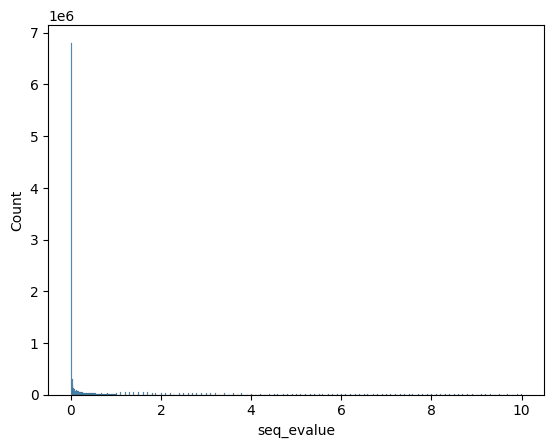

In [27]:
sns.histplot(data=seq_evalues, x='seq_evalue', binwidth=0.02)

In [28]:
E_cutoff = 1E-3
filtered_dom_tbl = cat_dom_tbl[cat_dom_tbl['seq_evalue'] < E_cutoff].reset_index(drop=True)

In [29]:
query_count_df = filtered_dom_tbl['query'].value_counts().reset_index()

In [33]:
query_count_df

,query,count
0,WP_064766070.1,2896866
1,WP_001676491.1,1579359
2,WP_087889773.1,1396841
3,WP_059339975.1,547530
4,WP_000770925.1,298911
5,WP_032203427.1,281223
6,WP_042346724.1,247231
7,WP_001589054.1,230915
8,WP_040091717.1,201175
9,WP_001619161.1,190474


In [34]:
def calculate_total_alignment_length(df, from_col, to_col):
    # Ensure the dataframe is sorted by 'from_col'
    df_sorted = df.sort_values(from_col)
    # Initialize the list to hold merged intervals
    merged_intervals = []
    # Iterate through sorted dataframe rows
    for _, row in df_sorted.iterrows():
        if not merged_intervals:
            # Start with the first interval
            merged_intervals.append([row[from_col], row[to_col]])
        else:
            # Get the last interval in the list
            last_interval = merged_intervals[-1]
            # Check if current interval overlaps with the last interval in the list
            if row[from_col] <= last_interval[1]:
                # Merge the intervals by extending the last interval
                last_interval[1] = max(last_interval[1], row[to_col])
            else:
                # No overlap, add the current interval as a new one
                merged_intervals.append([row[from_col], row[to_col]])
    # Calculate the total length of all non-overlapping intervals
    total_length = sum(interval[1] - interval[0] + 1 for interval in merged_intervals)
    return total_length

In [35]:
def calc_ali_lens(group_df, target, query, evalue):
    target_ali_len = calculate_total_alignment_length(group_df, 'env_from', 'env_to')
    query_ali_len = calculate_total_alignment_length(group_df, 'hmm_from', 'hmm_to')
    return {'target': target, 'query': query, 'target_ali_len':target_ali_len, 'query_ali_len': query_ali_len, 'evalue': evalue}

In [36]:
query_target_ali_lens = Parallel(n_jobs=48)(delayed(calc_ali_lens)
                                            (group_df, target, query, evalue) for
                                            (target, query, evalue), group_df in 
                                            tqdm(filtered_dom_tbl.groupby(['target', 'query', 'seq_evalue']), 
                                                 total=len(filtered_dom_tbl[['target', 'query']].drop_duplicates()), 
                                                 position=0))

100%|██████████| 5758447/5758447 [1:00:28<00:00, 1587.01it/s]


In [37]:
filtered_dom_tbl.head()

,target,target_accession,tlen,query,query_accession,qlen,seq_evalue,seq_score,seq_bias,dom_n,...,dom_score,dom_bias,hmm_from,hmm_to,ali_from,ali_to,env_from,env_to,acc,targ_description
0,396d5e92780c00697bc1653fd687aed05a317e5d6db226...,-,581.0,WP_016240614.1,-,583.0,5.000000e-207,700.8,0.0,1.0,...,700.6,0.0,1.0,583.0,1.0,581.0,1.0,581.0,0.99,-
1,dc8c5ccb32de6e3004d5c8924d8f0e6a7c1f9c20f6f956...,-,581.0,WP_016240614.1,-,583.0,7.800000e-206,696.8,0.0,1.0,...,696.7,0.0,1.0,582.0,1.0,580.0,1.0,581.0,0.99,-
2,1af8afa92bca3becbc647a153db01d8d6e822148854192...,-,581.0,WP_016240614.1,-,583.0,1.300000e-205,696.1,0.0,1.0,...,695.9,0.0,1.0,583.0,1.0,581.0,1.0,581.0,0.99,-
3,10d7f1c647fa49b40bc48f158cd64c45d8979aaf323e2a...,-,581.0,WP_016240614.1,-,583.0,9.200000e-203,686.7,0.0,1.0,...,686.5,0.0,1.0,583.0,1.0,581.0,1.0,581.0,0.99,-
4,670cc0d7d23919395cddf2c1ef43f7cb15f0f0a0a31190...,-,581.0,WP_016240614.1,-,583.0,2.000000e-202,685.6,0.0,1.0,...,685.4,0.0,1.0,583.0,1.0,581.0,1.0,581.0,0.99,-


In [38]:
unique_query_targets = filtered_dom_tbl[['target', 'query', 'tlen','qlen']].drop_duplicates()

In [39]:
query_target_ali_len_df = (pd.DataFrame(query_target_ali_lens)
                           .merge(unique_query_targets, how='inner', on=['query', 'target']))
query_target_ali_len_df['q_ali_frac'] = query_target_ali_len_df['query_ali_len']/query_target_ali_len_df['qlen']
query_target_ali_len_df['t_ali_frac'] = query_target_ali_len_df['target_ali_len']/query_target_ali_len_df['tlen']
query_target_ali_len_df['neg_log_evalue'] = -np.log10(query_target_ali_len_df['evalue'])

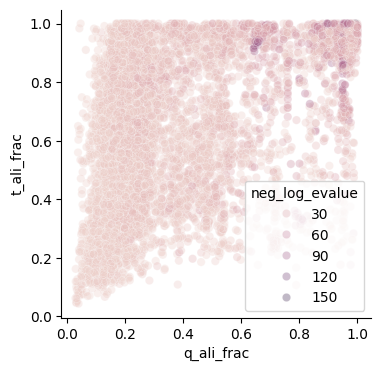

In [40]:
plt.subplots(figsize=(4,4))
sns.scatterplot(data=query_target_ali_len_df.sample(n=10_000, random_state=7), 
                hue='neg_log_evalue', x='q_ali_frac', y='t_ali_frac', alpha=0.33)
sns.despine()

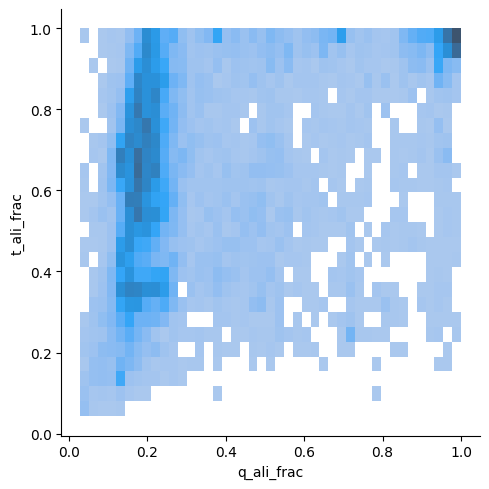

In [41]:
sns.displot(data=query_target_ali_len_df.sample(n=10_000, random_state=7),
            x='q_ali_frac', y='t_ali_frac')

In [42]:
filtered_query_targets = query_target_ali_len_df[(query_target_ali_len_df['t_ali_frac'] > 0.8) & 
                                                 (query_target_ali_len_df['q_ali_frac'] > 0.8)].reset_index(drop=True)

In [43]:
len(filtered_query_targets)/len(query_target_ali_len_df)

0.08330266823676592

In [44]:
filtered_query_targets['query'].value_counts()

query
WP_000770925.1    179483
WP_087900469.1     70938
WP_001619161.1     66402
WP_087889773.1     50145
WP_001702960.1     46970
WP_001593459.1     26219
WP_001676491.1     12066
WP_000355468.1      4581
WP_000389051.1      3965
WP_033812887.1      3815
WP_016240615.1      1937
WP_001198055.1      1743
WP_072044445.1      1705
WP_064766070.1      1211
WP_000210934.1       622
WP_000628292.1       569
WP_000097610.1       448
WP_059339975.1       405
WP_054626965.1       378
WP_032291790.1       370
WP_021513009.1       360
WP_020231147.1       349
WP_001313577.1       282
WP_047174762.1       258
WP_000150292.1       257
WP_000068158.1       240
WP_087900470.1       237
WP_001589054.1       235
WP_087897267.1       216
WP_016240614.1       210
WP_249925928.1       204
WP_001240354.1       194
WP_042346724.1       179
WP_040091717.1       170
WP_000257686.1       151
WP_032203427.1       151
WP_001557682.1       131
WP_061089765.1       125
WP_032260665.1       121
WP_087896215.1     

In [45]:
filtered_query_targets.to_csv('../data/interim/screen_hits_refseq_homologs.csv', index=False)

### From proteins to systems

For multi-protein system we'll look as to whether the proteins occur in an operon together

In [5]:
filtered_query_targets = pd.read_csv('../data/interim/screen_hits_refseq_homologs.csv')

In [6]:
%%time
refseq_seq_assemblies = pd.read_csv('../data/interim/seq_assemblies.csv', 
                                    names=['product_accession', 'seq_id', 'seq', 'assembly'])

CPU times: user 5min 1s, sys: 27.2 s, total: 5min 28s
Wall time: 5min 28s


In [7]:
%%time
hit_genomes = (refseq_seq_assemblies[refseq_seq_assemblies['seq_id'].isin(filtered_query_targets['target'])]
               .merge(filtered_query_targets, how='inner', left_on='seq_id', right_on='target'))

CPU times: user 11.4 s, sys: 528 ms, total: 11.9 s
Wall time: 12.7 s


In [8]:
feature_file_dir = '../data/genome_downloads/ft/'
feature_file_dict = {x[:13]: x for x in os.listdir(feature_file_dir) if '.txt' in x}

In [9]:
def get_system_homologs(system, system_df, feature_file_dir=feature_file_dir, 
                        feature_file_dict=feature_file_dict, hit_genomes=hit_genomes):
    system_size = len(system_df)
    system_genomes = hit_genomes.loc[hit_genomes['query'].isin(system_df['product_accession'])]
    system_genome_members = (system_genomes.groupby('assembly')
                           .agg(n_members=('query', 'nunique'))
                           .reset_index())
    system_plausible_genomes = system_genome_members.loc[(system_genome_members['n_members'] == system_size), 
                                                         'assembly']
    system_hit_list = []
    if len(system_plausible_genomes):
        system_genomes = system_genomes[system_genomes['assembly'].isin(system_plausible_genomes)]
        for assembly, assembly_df in system_genomes.groupby('assembly'):
            feature_file = feature_file_dir + feature_file_dict[assembly]
            feature_df = pd.read_table(feature_file)
            feature_df['attributes'] = feature_df['attributes'].astype(str)
            filtered_feature_df = (feature_df[(feature_df['# feature'] == 'CDS') &
                                              ~(feature_df['attributes'].str.contains('pseudo', na=False))]
                                   .reset_index(drop=True))
            merged_feature_df = (filtered_feature_df.reset_index()
                                 .merge(assembly_df.drop(columns=['assembly']), how='inner', on='product_accession')
                                 .set_index('index')
                                 .sort_index())
            sys_num = 0
            for i in merged_feature_df.index:
                window_df = merged_feature_df.loc[i:(i+system_size+1),:].copy()
                if window_df['query'].nunique() == system_size:
                    window_df['system'] = system 
                    window_df['assembly_system'] = system + '_' + str(sys_num)
                    sys_num += 1
                    system_hit_list.append(window_df)
    if len(system_hit_list):
        system_hit_df = pd.concat(system_hit_list)
        return system_hit_df
    else:
        return None

In [10]:
%%time
all_system_list = Parallel(n_jobs=48)(delayed(get_system_homologs)(system, system_df)
                                      for system, system_df in tqdm(systems_df.groupby('working_id'), 
                                                                    total=systems_df['working_id'].nunique(), 
                                                                    position=0))

100%|██████████| 45/45 [00:00<00:00, 69.57it/s]


CPU times: user 43.2 s, sys: 30.7 s, total: 1min 13s
Wall time: 8min 53s


In [ ]:
all_system_df = pd.concat(all_system_list)

In [ ]:
all_system_df.to_csv('../data/interim/hit_system_refseq_homologs.csv', index=False)

## Visualize system abundance

In [29]:
all_system_df = pd.read_csv('../data/interim/hit_system_refseq_homologs.csv')
all_system_df = all_system_df[all_system_df['system'].isin(systems_df['working_id'].unique())]

In [8]:
system_name_df = pd.read_csv('../data/raw/Beaker validation domains - system_display_names.csv')

In [9]:
ncbi_taxonomy = pd.read_csv('../data/interim/refseq_genome_summary.csv')

/tmp/ipykernel_892426/3001054450.py:1: DtypeWarning: Columns (34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  ncbi_taxonomy = pd.read_csv('../data/interim/refseq_genome_summary.csv')


In [7]:
taxonomy_nodes = pd.read_table('../data/raw/nodes.dmp', 
                               sep='\t\|\t', 
                               names=['tax_id', 'parent tax_id', 'rank', 'embl code', 'division id', 
                                      'inherited div flag', 'genetic code id', 'inherited GC flag', 
                                      'mitochondrial genetic code id', 'inherited MGC flag', 
                                      'GenBank hidden flag', 'hidden subtree root flag', 'comments'])

/tmp/ipykernel_3627372/3281153549.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  taxonomy_nodes = pd.read_table('../data/raw/nodes.dmp',


In [10]:
taxonomy_names = pd.read_table('../data/raw/names.dmp', 
                               sep='\t\|\t', 
                               names=['tax_id', 'name_txt', 'unique name', 'name class'])
taxonomy_names['name class'] = taxonomy_names['name class'].str[:-2]

/tmp/ipykernel_892426/1187526047.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  taxonomy_names = pd.read_table('../data/raw/names.dmp',


In [15]:
rep_taxonomy = ncbi_taxonomy[ncbi_taxonomy['domain'].isin(['B', 'A']) & 
                             (ncbi_taxonomy['refseq_category'] != 'na')]

In [10]:
def get_taxonomy_dict(df, tax_id):
    taxonomy_dict = {}
    current_tax_id = tax_id
    row = df[df['tax_id'] == current_tax_id].squeeze()
    while row['tax_id'] != row['parent tax_id']:
        row = df[df['tax_id'] == current_tax_id].squeeze()
        taxonomy_dict[row['rank']] = row['tax_id']
        current_tax_id = row['parent tax_id']
    return taxonomy_dict

In [11]:
rep_lineage_list = list()
for species in tqdm(rep_taxonomy['species_taxid'], position=0):
    lineage = get_taxonomy_dict(taxonomy_nodes, species)
    rep_lineage_list.append(lineage)

100%|██████████| 18474/18474 [02:23<00:00, 128.87it/s]


In [12]:
rep_lineage_df = pd.DataFrame(rep_lineage_list)

In [ ]:
rep_lineage_df.to_csv('../data/interim/rep_species_lineage.csv', index=False)

In [11]:
rep_lineage_df = pd.read_csv('../data/interim/rep_species_lineage.csv')

In [12]:
scientific_names = (taxonomy_names.loc[taxonomy_names['name class'] == 'scientific name', 
                                       ['tax_id', 'name_txt']]
                    .rename(columns={'name_txt': 'name'}))

In [13]:
top_n = 16
top_classes = (rep_lineage_df[['class','phylum', 'superkingdom']]
               .value_counts()
               .head(top_n)
               .reset_index()
               .rename(columns={'count': 'background_count'}))
top_classes = (top_classes
               .merge(scientific_names.rename(columns={'name': 'class_name', 
                                                       'tax_id': 'class'}), 
                      on='class')
               .merge(scientific_names.rename(columns={'name': 'phylum_name', 
                                                       'tax_id': 'phylum'}), 
                      on='phylum')
               .merge(scientific_names.rename(columns={'name': 'domain_name', 
                                                       'tax_id': 'superkingdom'}), 
                      on='superkingdom')
               .sort_values(['superkingdom', 'phylum', 'class']))
top_classes['display_class_name'] = top_classes['class_name'] + ' (n=' + top_classes['background_count'].astype(str) + ')'
# Add count of one for genome system was found in
top_classes.loc[top_classes['class_name'] == 'Gammaproteobacteria', 'background_count'] += 1

In [49]:
merged_system_df = (all_system_df
                    .drop(columns='class')
                    .merge(rep_taxonomy
                                        .rename(columns={'#assembly_accession': 'assembly'}), 
                                        how='inner', on='assembly')
                    
                    .merge(rep_lineage_df.rename(columns={'species': 'species_taxid'}), 
                           how='inner', on='species_taxid'))

In [51]:
system_class_count_temp = (merged_system_df.groupby('system')
                      .agg(gamma = ('class', lambda x: (x == 1236).any()), 
                           n_classes = ('class', 'nunique'))
                      .reset_index()
                           .merge(system_name_df
                                  .rename(columns={'working_id': 'system'}))
                      .sort_values('n_classes'))
system_class_count_temp

,system,gamma,n_classes,DS_name,replicated
9,D668,True,1,DS-43,True
22,NTTI,True,1,DS-4,True
37,TMO1,True,1,DS-13,True
6,ANEX,True,1,DS-28,True
7,D295,True,2,DS-40,True
5,ABC3,True,3,DS-30,True
24,PD3A,True,4,DS-12,True
25,PDP4,True,4,DS-19,True
27,PIN8,False,4,DS-3,True
17,MHAD,True,4,DS-9,True


In [53]:
all_system_names = system_name_df.loc[:, 'DS_name']
all_system_names[~all_system_names.isin(system_class_count_temp['DS_name'])]

4      DS-5
32    DS-34
Name: DS_name, dtype: object

In [54]:
pd.set_option('display.max_columns', 100)
merged_system_df[merged_system_df['system'] == 'NERD'].sample(5, random_state=7)

,# feature,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non-redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes,seq_id,seq,target,query,target_ali_len,query_ali_len,evalue,tlen,qlen,q_ali_frac,t_ali_frac,neg_log_evalue,system,assembly_system,bioproject,biosample,wgs_master,refseq_category,taxid,species_taxid,organism_name,infraspecific_name,isolate,version_status,assembly_level,release_type,genome_rep,seq_rel_date,asm_name,asm_submitter,gbrs_paired_asm,paired_asm_comp,ftp_path,excluded_from_refseq,relation_to_type_material,asm_not_live_date,assembly_type,group,genome_size,genome_size_ungapped,gc_percent,replicon_count,scaffold_count,contig_count,annotation_provider,annotation_name,annotation_date,total_gene_count,protein_coding_gene_count,non_coding_gene_count,pubmed_id,domain,species group,genus,tribe,family,order,class,phylum,superkingdom,no rank,clade,subclass,suborder,species subgroup,subfamily,subgenus,kingdom
7641,CDS,GCF_001047375.1,Primary Assembly,unplaced scaffold,NaN,NZ_LFVU01000003.1,102327,103898,-,WP_048569448.1,WP_048569448.1,NaN,hypothetical protein,NaN,NaN,CLCY_RS01900,1572,523.0,NaN,720879719017fc3d26a1f7c820b5c04ca97abdda4b9680...,MSKTDEVVGFLSKYSLEDVLSGIIEMQMLLYGQGVDSLISASEYFV...,720879719017fc3d26a1f7c820b5c04ca97abdda4b9680...,WP_054626965.1,515.0,466.0,2.700000e-27,523.0,525.0,0.887619,0.984704,26.568636,NERD,NERD_0,PRJNA224116,SAMN03794733,LFVU00000000.1,representative genome,1121307,1495,Clostridium cylindrosporum DSM 605,strain=DSM 605,na,latest,Contig,Major,Full,2015/07/07,ASM104737v1,Goettingen Genomics Laboratory,GCA_001047375.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,na,assembly from type material,na,haploid,bacteria,2735032,2735032,31.5,0,28,28,NCBI RefSeq,GCF_001047375.1-RS_2024_04_12,2024/04/12,2708,2613,81,26272578,B,NaN,1485.0,NaN,31979.0,186802.0,186801.0,1239.0,2,1,1783272.0,NaN,NaN,NaN,NaN,NaN,NaN
962,CDS,GCF_000761485.1,Primary Assembly,unplaced scaffold,NaN,NZ_JPMX01000003.1,122942,124852,-,WP_156118988.1,WP_156118988.1,NaN,hypothetical protein,NaN,NaN,IN07_RS01255,1911,636.0,NaN,674589e78c3302bc887f2257870bf40154fcc7d0947913...,MQARQPGTSAQLRVQLARLRTVFAGRETGAVRTHLTPITDGQVMVT...,674589e78c3302bc887f2257870bf40154fcc7d0947913...,WP_054626965.1,538.0,482.0,3.000000e-48,636.0,525.0,0.918095,0.845912,47.522879,NERD,NERD_0,PRJNA224116,SAMN02918181,JPMX00000000.1,representative genome,1522368,1522368,Modestobacter caceresii,strain=KNN 45-2b,na,latest,Scaffold,Major,Full,2014/10/01,ASM76148v1,"Institute of Biology, Leiden University",GCA_000761485.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,na,assembly from type material,na,haploid,bacteria,4953652,4948700,73.5,0,139,139,NCBI RefSeq,NCBI Prokaryotic Genome Annotation Pipeline (P...,2024/02/11,4795,4675,54,na,B,NaN,88138.0,NaN,85030.0,1643682.0,1760.0,201174.0,2,1,1783272.0,NaN,NaN,NaN,NaN,NaN,NaN
7624,CDS,GCF_000521505.1,Primary Assembly,chromosome,NaN,NZ_CP003915.1,865220,866785,+,WP_025371473.1,WP_025371473.1,NaN,hypothetical protein,NaN,NaN,MIM_RS03995,1566,521.0,NaN,448045d904be16f93b9875b176dc6e565c377f0cb327ad...,MVKFSDQIYQQKLKKIKRELNKFLSRTDDKLFLQFMWSINTLQTEF...,448045d904be16f93b9875b176dc6e565c377f0cb327ad...,WP_054626965.1,509.0,462.0,2.100000e-82,521.0,525.0,0.880000,0.976967,81.677781,NERD,NERD_0,PRJNA224116,SAMN02641504,na,representative genome,1247726,302406,Advenella mimigardefordensis DPN7,strain=DPN7,na,latest,Complete Genome,Major,Full,2014/01/22,ASM52150v1,"Georg-August-University Goettingen, Genomic an...",GCA_000521505.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,na,assembly from type material,na,haploid,bacteria,4764126,4764126,54.0,2,2,2,NCBI RefSeq,NCBI Prokaryotic Genome Annotation Pipeline (P...,2023/12/24,4380,4289,51,24739217,B,NaN,290425.0,NaN,506.0,80840.0,28216.0,1224.0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7776,CDS,GCF_016863455.1,Primary Assembly,unplaced 

In [56]:
system_class_count = (merged_system_df
                      .groupby(['system', 'class'])
                      .agg(system_count=('assembly', 'nunique'))
                      .reset_index())
existing_gamma_systems = system_class_count.loc[system_class_count['class'] == 1236,'system'].to_list()
missing_gamma_systems = [x for x in system_name_df.loc[:, 
                                                       'working_id'] if x not in existing_gamma_systems]
system_class_count = pd.concat([system_class_count, 
                                pd.DataFrame([{'system': x,  
                                               'class': 1236,
                                               'system_count': 1} for x in missing_gamma_systems])])

In [57]:
missing_gamma_systems

['PIN8', 'PN12', 'CITO']

In [58]:
system_total_counts = (system_class_count.groupby('system')
                       .agg(total_system_count=('system_count', 'sum'))
                       .reset_index())

In [59]:
merged_system_class_count = (top_classes
                             .merge(system_class_count.rename(columns={'count': 'system_count'}), 
                                    how='inner', on='class')
                             .merge(system_total_counts, how='inner', on='system'))
merged_system_class_count['system_frac'] = merged_system_class_count['system_count']/merged_system_class_count['background_count']
merged_system_class_count['log_frac'] = np.log10(merged_system_class_count['system_frac'])
merged_system_class_count['display_class_name'] = pd.Categorical(merged_system_class_count['display_class_name'], 
                                                    categories=top_classes['display_class_name'])
merged_system_class_count['class_name'] = pd.Categorical(merged_system_class_count['class_name'], 
                                                    categories=top_classes['class_name'])


In [62]:
merged_system_class_count[merged_system_class_count['class_name']== 'Halobacteria']

,class,phylum,superkingdom,background_count,class_name,phylum_name,domain_name,display_class_name,system,system_count,total_system_count,system_frac,log_frac
30,183963.0,28890.0,2157,349,Halobacteria,Euryarchaeota,Archaea,Halobacteria (n=349),AAA2,114,3069,0.326648,-0.485921
96,183963.0,28890.0,2157,349,Halobacteria,Euryarchaeota,Archaea,Halobacteria (n=349),HEP3,6,120,0.017192,-1.764674
168,183963.0,28890.0,2157,349,Halobacteria,Euryarchaeota,Archaea,Halobacteria (n=349),NERD,4,350,0.011461,-1.940765


In [61]:
system_stats = (merged_system_class_count.groupby('system')
                .agg(frac_mean=('system_frac', 'mean'),
                     n_classes=('class_name', 'nunique'))
                .reset_index()
                   .sort_values(['n_classes', 'frac_mean'], ascending=False))
system_stats

,system,frac_mean,n_classes
3,AAA2,0.159594,16
22,NERD,0.023981,16
27,PDX1,0.021631,15
12,E2DP,0.017856,14
19,MNAC,0.012391,14
16,HIPA,0.028141,13
24,NUCS,0.011271,13
4,AAA5,0.010395,13
37,SMEK,0.008620,13
35,RMOR,0.011753,12


In [63]:
system_stat_names = (system_stats.merge(system_name_df
                                        .rename(columns={'working_id': 'system'}), 
                                        how='inner', on='system')
                     .merge(system_total_counts, how='inner', on='system')
                     .sort_values(['n_classes','frac_mean'], ascending=False))
system_stat_names['display_name_count'] = system_stat_names['DS_name'] + ' (n=' + system_stat_names['total_system_count'].astype(int).astype(str) + ')'


### Plot novel taxonomy

In [64]:
novel_domain_systems = ['D390', 'DISA', 'PIN8', 'NTTI',  
                        'PN12', 'HIPA', 'SVIR', 'MNAC', 'MHAD', 'ZAPB','IMPD']

In [65]:
novel_system_count = (merged_system_class_count.loc[merged_system_class_count['system']
                                                    .isin(novel_domain_systems), :]
                      #.merge(system_name_df, how='inner', on='system')
                      .merge(system_stat_names, how='inner', on='system'))
novel_system_stat_names = (system_stat_names.loc[system_stat_names['system'].isin(novel_domain_systems)])
novel_system_count['display_name_count'] = pd.Categorical(novel_system_count['display_name_count'], 
                                                    categories=novel_system_stat_names['display_name_count'])


In [66]:
wide_novel_system_frac = novel_system_count.pivot_table(index='display_class_name', 
                                                        columns='display_name_count', values='log_frac', dropna=False)

In [67]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size']  = 7

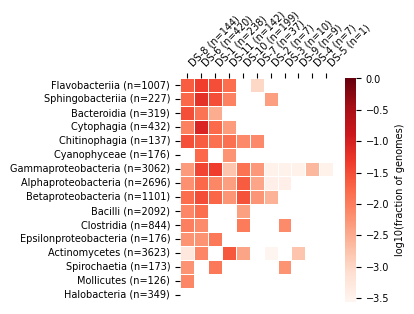

In [68]:
plt.subplots(figsize=(2.9,2.9))
sns.heatmap(data=wide_novel_system_frac, cmap='Reds', 
            vmax=0, cbar_kws={'label': 'log10(fraction of genomes)'}, 
            linewidth=0.5, square=True)
plt.xlabel('')
plt.ylabel('')
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=45, ha='left')

plt.savefig('../figures/novel_domain_hit_taxonomy.svg', dpi=300, bbox_inches='tight')

### Plot other taxonomy

In [69]:
other_system_count = (merged_system_class_count.loc[~merged_system_class_count['system']
                                                    .isin(novel_domain_systems), :]
                      #.merge(system_name_df, how='inner', on='system')
                     .merge(system_stat_names, how='inner', on='system'))
other_system_stat_names = (system_stat_names.loc[~system_stat_names['system'].isin(novel_domain_systems)])
other_system_count['display_name_count'] = pd.Categorical(other_system_count['display_name_count'], 
                                                    categories=other_system_stat_names['display_name_count'])

In [76]:
other_system_count.query("phylum_name != 'Pseudomonadota'")['system'].nunique()

24

In [70]:
wide_other_system_frac = other_system_count.pivot_table(index='display_class_name', 
                                                        columns='display_name_count', values='log_frac', dropna=False)

In [71]:
wide_other_system_frac.shape

(16, 31)

In [72]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size']  = 6

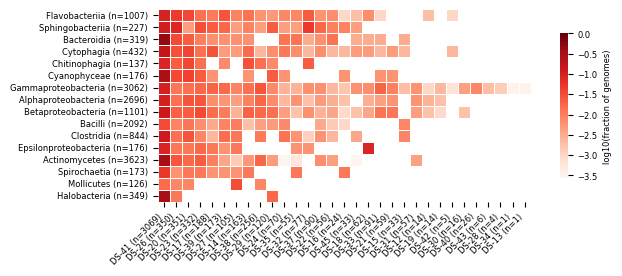

In [73]:
plt.subplots(figsize=(7.7,2.5))
sns.heatmap(data=wide_other_system_frac, cmap='Reds', 
            vmax=0, cbar_kws={'label': 'log10(fraction of genomes)', 
                               'shrink': 0.75}, 
            linewidth=0.5, square=True)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.savefig('../figures/other_domain_hit_taxonomy.svg', dpi=300, bbox_inches='tight')